### Imports

In [1]:
# ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

import cv2
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import random_split

# Plots
import matplotlib.pyplot as plt

# Utils
import numpy as np
from collections import OrderedDict
from tqdm import tqdm, trange
import os

D:\Lucru\github-folder\hacktm-2022\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load dataset

In [28]:
# The ImageFolder dataset
transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
dataset = torchvision.datasets.ImageFolder(r'D:/Lucru/github-folder/hacktm-2022/dataset-aug/', transform=transform)

In [29]:
dataset.classes

['organic', 'recyclable']

In [30]:
train_len = int(.80 * len(dataset))
test_len = len(dataset) - train_len
train_dataset, test_dataset = random_split(dataset, [train_len, test_len])

In [34]:
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)
samples, labels = next(iter(dataloader))

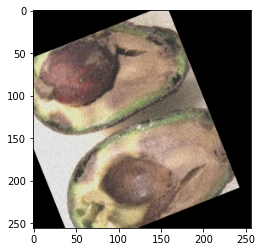

In [40]:
plt.imshow(samples[0].T)

### Model training

In [41]:
resnet18 = torchvision.models.resnet18(pretrained = True)

In [42]:
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512, 128)),
    ('dropout', nn.Dropout(p = .5)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(128, 2)),
    ('output', nn.LogSoftmax(dim=1))
]))
resnet18.fc = fc

In [43]:
# Unfreeze last layer
for param in resnet18.fc.parameters():
    param.requires_grad = True

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')
resnet18 = resnet18.to(device)

device: cuda


In [45]:
learning_rate = .001
optimizer = torch.optim.Adam(resnet18.parameters(), lr=learning_rate) # change resnet here
#optimizer = torch.optim.Adam(resnet18.parameters(), lr=learning_rate) # change resnet here
loss_function = nn.CrossEntropyLoss()

batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size)

In [46]:
epochs = 10
accs = []
losses = []
val_losses = []
val_accs = []
for epoch in (t:= trange(epochs)):
    resnet18.train() # change resnet here
    # Get batches
    loss = 0.
    acc = 0.
    num_batches = 0
    for X_batch, y_batch in trainloader:
        num_batches+=1
        X_batch = X_batch.cuda()
        y_batch = y_batch.cuda()
        y_pred = resnet18(X_batch)
        
        loss_batch = loss_function(y_pred, y_batch)    
        loss += loss_batch.item()
        acc += accuracy_score(torch.argmax(y_pred.cpu(), axis = 1), y_batch.cpu())
        
        optimizer.zero_grad() # don't forget this
        loss_batch.backward()
        optimizer.step()
    
    acc /= num_batches
    loss /= num_batches
    losses.append(loss)
    accs.append(acc)

    # Validation set
    resnet18.eval()
    num_batches = 0
    val_acc = 0.
    val_loss = 0.
    for X_batch, y_batch in testloader:
        num_batches+=1
        X_batch = X_batch.cuda()
        y_batch = y_batch.cuda()
        
        y_pred = resnet18(X_batch)
        val_acc += accuracy_score(torch.argmax(y_pred.cpu(), axis = 1), y_batch.cpu())
        loss_batch = loss_function(y_pred, y_batch)    
        val_loss += loss_batch.item()
        
    val_acc /= num_batches
    val_loss /= num_batches
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    t.set_description(f"(Loss, Acc) -- Train : {round(loss, 2), round(acc, 2)}, Test : {round(val_loss, 2), round(val_acc, 2)}")

(Loss, Acc) -- Train : (0.01, 1.0), Test : (0.04, 0.99): 100%|█████████████████████████| 10/10 [07:02<00:00, 42.29s/it]


In [47]:
del X_batch, y_batch
torch.cuda.empty_cache()

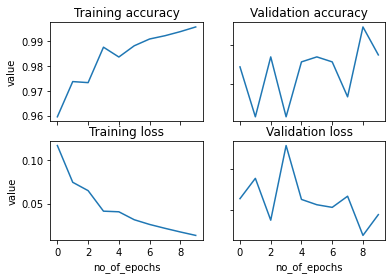

In [59]:
fig, axs = plt.subplots(2,2)
axs[0, 0].plot(range(epochs), accs)
axs[0, 0].set_title('Training accuracy')
axs[0, 1].plot(range(epochs), val_accs)
axs[0, 1].set_title('Validation accuracy')
axs[1, 0].plot(range(epochs), losses)
axs[1, 0].set_title('Training loss')
axs[1, 1].plot(range(epochs), val_losses)
axs[1, 1].set_title('Validation loss')

for ax in axs.flat:
    ax.set(xlabel='no_of_epochs', ylabel='value')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [61]:
torch.save(resnet18.state_dict(), r"D:/Lucru/github-folder/hacktm-2022/my_resnet18.pth")